<a href="https://colab.research.google.com/github/akhavan12/discrete_covid_model/blob/master/V4_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## relations
###  S(t) = M(t) + W(t)
###  Recovery length for each type is different 
###  K is the distribution of the number of the sever cases that need ventilators

In [0]:
## Testin Dynamics model

### Testing / population
### Testing ==> Positive / Negative
##### Pisitive case in MILD cases (X_m(t)) / Pisitive case in Severe cases (X_s(t)1)
### back tracking to see the distribution 

### figuring out the number of the asymptomatics
### T(t) = W(t) + X_m(t) * M(t)
### There should be a relation between the number of the tested cases and all the symptomatic cases

##
##                                         | Recovery process R(t+dt)
##                               | M(t) ---
##                       | P(t)---          | Goes sever W(t)
# Ex(t)->A(t)->(G_t) -S(t)        |
##                       |        | W(t) ---| Recovery process  R(t+dt)
##                       |                  | Goes Ventilatoe V(t) with distribution k(t-t')
##                       |                                               |V(t)--------| Recovery process R(t+dt2) with time. R(t+dt')
##                       |                                                            | Death 
##                       |
##                       | N(t)                    

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import random

In [0]:
## public variables
population = 100
##### Percentages:
Ex_to_A = .60  ## exposed to asymptomatic (epsilon)
A_to_S = .90  ## Asymptomatic to Symptomatic  
S_to_M = .999 ## percentage from Sympt to Mild ~~100%
M_to_W = .1   ## Mild to Severe daily percentage
W_to_V = .06  ## sever to ventilator
W_to_D = .04  ## Sever to death each day
W_to_R = .30  ## Sever  to recovery each day
V_to_D = .10  ## Ventilator to death each day
V_to_R = .20  ## Ventilator to recovery each day


##### Final states

delay_Ex_to_none= 14
delay_A_to_S = 5   ## days incubation incubation period: the period of time between exposure to an infection and when symptoms
Max_S_to_M = 14  ## days incubation incubation period: the period of time between exposure to an infection and when symptoms
delay_M_to_R = 15 ## days mild to recovery ==> after this many days the mild case is considered recovered
delay_M_to_W = 4
Min_W_to_V = 2   ## days severe to ventilator 
Min_W_to_R = 10
Min_V_to_D = 10 ## days ventilator to death
delay_W_to_R = 14 ## days mild to recovery
delay_V_to_R = 25 ## days mild to recovery

## public functions
## this function returns True or False based on a percentage of probability
def decision(probability):
    return random.random() < probability


cum_sum_dict={
      "cumulative_Exposed"   :[],
      "cumulative_Asympt"    :[],
      "cumulative_Sympt"     :[],
      "cumulative_Mild"      :[],
      "cumulative_Severe"    :[],
      "cumulative_Ventilator":[],
      "cumulative_Dead"     :[],
      "cumulative_Recovered" :[],
      "cumulative_Healthy"   :[]
    }

In [0]:
def initialize(inital_expose=10):

  Ex =np.int16(np.zeros(population)) ## Exposed 
  A = np.int16(np.zeros(population)) ## number of asymptomatic cases at time t
  S = np.int16(np.zeros(population)) ## number of symptomatic cases at time t
  M = np.int16(np.zeros(population)) ## number of mild cases at time t
  W = np.int16(np.zeros(population)) ## number of sever cases at time t  
  V = np.int16(np.zeros(population)) ## number of the ventilator cases 
  D = np.int16(np.zeros(population)) ## number of the dead cases
  R = np.int16(np.zeros(population)) ## Recovered cases
  H = np.int16(np.zeros(population)) ## Number of Healthy


  ## random exposed people:
  for i in range(inital_expose):
    Ex[np.random.randint(0,population,1)]=1

  ## moving status Matrix:
  df_s_m = pd.DataFrame({
     "Exposed"    : Ex,
     "Asympt"     : A,
     "Sympt"      : S,
     "Mild"       : M,
     "Severe"     : W,
     "Ventilator" : V,
     "Dead"       : D,
     "Recovered"  : R,
     "Healthy"    : H
  })
  
  return df_s_m
 

In [0]:
def run_simulation(df_population,length=60):
    ## new_cases is the number of newly infected people.

    global new_cases
    ## make empty variables too keep the time series at each round. Later they will be used to make the final table.

 #1)##############        aggregation of all the records          ############### 
 ############### in the main population dataframe and           ###############
 ############### calculates cumulative values until that point  ###############
    def check_increment(df_,col,lim_=0):
      temp_count = 0
      temp_count = df_[df_[col]>0][col].count()
      return temp_count

    def aggregate():
      global df_population
      global cum_sum_dict

      for col in df_population.columns:
        cum_sum_dict[f'cumulative_{col}'].append(check_increment(df_population.copy(),col))

 #############################################################################
 #############################################################################
 ############################################################################# 


 #2)############## loop over time to update the population dataframe##############
    ## length is the duration of the process
    
    for i in tqdm.tqdm_notebook(range(length)):
        df_population = df_population.apply(increment_infected_days,axis=1) ## apply the function


 #############################################################################
 #############################################################################
 ############################################################################# 

 #3)############################ Update function ############################
    ## length is the duration of the process
    aggregate() ### aggregate the results




In [105]:
df_population=initialize()
df_population.head(1)

,Exposed,Asympt,Sympt,Mild,Severe,Ventilator,Dead,Recovered,Healthy
0,0,0,0,0,0,0,0,0,0


In [117]:
## simmulate based on each day's cases and the probability of infection
def increment_infected_days(row):
    ## if a person is infected, and his/her infection is less than 14 days,
    ## he is considered infected
    
    if (row['Exposed'] >0) & (row['Exposed'] <= delay_Ex_to_none) : 
      ## increment t+1
      row['Exposed'] = row['Exposed']+1
      print('Condition 1')
      ## if exposed=0 then the person is not exposed yet, 
      ## if exposed above 1, it shows the days from exposure 
      ## if exposed = -1, the person is infected                       
         ### if exposed ===> epsilon * E is the percentage of the person exposed to be infected 
         ###  decision ---> uniform random numbers and percentage
      if decision(Ex_to_A) == True:
        ## the exposed person is infected now (Asympt)!
        row['Asympt'] = 1
        ##Take the person out of exposed group -epsilon*E
        row['Exposed'] = -1
    
    elif row['Exposed'] == -1:
      if row['Asympt']> 0:
        row['Asympt']=row['Asympt']+1 ## t=t+1
      ## if Asympt=0 then the person is not exposed yet, 
      ## if Asympt above 1, it shows the days from Asympt 
      ## if Asympt = -1, the person is now out of Asympt ==> Mild

        if row['Asympt'] > delay_A_to_S: ### the period from A to S is done:
          row['Asympt'] = -1 ## not the case is no more Asympt 
          if decision(A_to_S) == True: ## the pecentage from A to S
            row['Sympt'] = 1
          else:
            row['Recovered'] = 1 ## if the max time from A to S passes
                                 ## and the decision is Negative
                                 ## the person is not recovered
      
      elif row['Exposed'] >= delay_Ex_to_none:
        print('delay_Ex_to_none')
        row['Exposed'] = 0



    return row

IndentationError: ignored

In [95]:
df_population=initialize()
df_population.head(1)
run_simulation(df_population,length=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


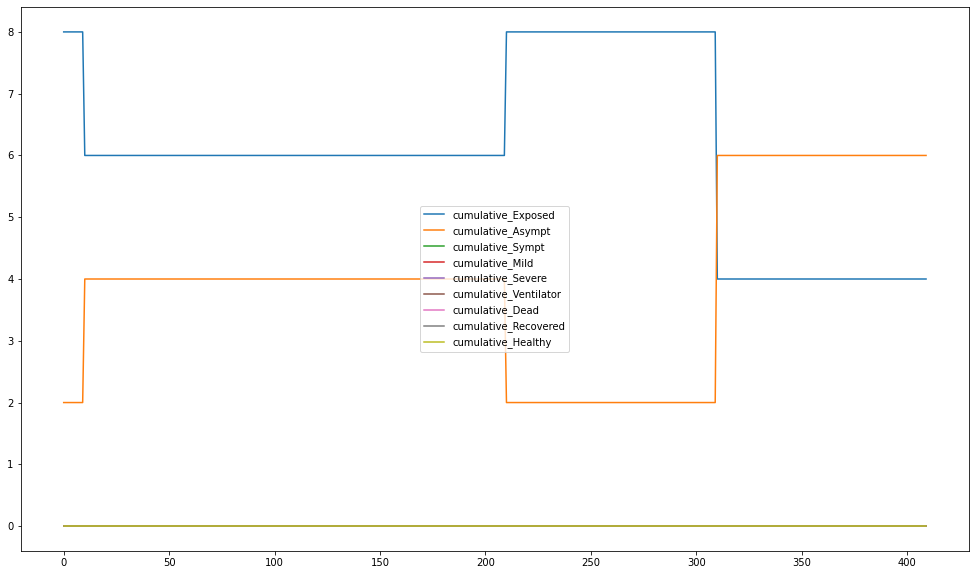

In [96]:
df_cumsum = pd.DataFrame(cum_sum_dict)
f,ax = plt.subplots(figsize=(17,10))
df_cumsum.plot(ax=ax)

In [0]:
"""

      if row['Sympt'] > 0:
        row['Sympt']= row['Sympt']+1 ## t=t+1 ==> the person is not infected and has sympt
        ## let us take him into mild if the max time from S to M is not passed 
        if row['Sympt'] < Max_S_to_M:
          if decision(S_to_M) == True:
            row['Mild'] = 1
            row['Sympt'] = -1 ## case is now Mild and no more S 
        else: ## the Sympt person does not become Mild in Max_S_to_M he is considered recovered
            row['Sympt'] = -1 ## case is now recovered
            row['Recovered'] = 1 ## if the Max_S_to_M is passed the person has already recovered


      if row['Mild']>0:
        row['Mild']=row['Mild']+1 ## t=t+1
        
        if row['Mild'] > delay_M_to_R : # the case has already been long in mild, and now is recovered
          row['Mild'] = -1 ## case is no more infected in mild and is recovered
          row['Recovered'] = 1 
           ### before the recovery period is passed
           ### after the window from M to W
           ## the person has M_to_W chance to go to SEVERE every day before the period
        elif (row['Mild'] <= delay_M_to_R) &(row['Mild'] >= delay_M_to_W) & decision(M_to_W) == True: 
          
          row['Mild'] = -1 ## the case is no more Mild and now is severe
          row['Severe'] = 1 ## the case is now severe
      
      
      if row['Severe'] > 1: ## check if the person is Severe
        row['Severe'] = row['Severe']+1
        if  row['Severe'] > delay_W_to_R: ## the case has been passed the period and now has recovered
          row['Severe'] = -1 ## the case is no more Severe and has recovered
          row['Recovered'] = 1
        elif (row['Severe'] > Min_W_to_V ) & decision(W_to_V)==True: ## in the period to go worse or stay sever until recovery/death
            ## goes to Ventilator status
            row['Severe'] = -1 ## the case is no more Severe 
            row['Ventilator'] = 1  ## the case is ventilatored
        elif (row['Severe'] > Min_W_to_R ) & decision(W_to_R)==True: ## in the period to go worse or stay sever until recovery/death
            ## goes to Ventilator status
            row['Severe'] = -1 ## the case is no more Severe 
            row['Recovered'] = 1  ## the case is ventilatored
        elif (row['Severe'] > Min_W_to_D) & (decision(W_to_D)==True):
            ## the cases passes away
            row['Severe'] = -1 ## the case is no more Severe
            row['Dead'] = 1 ## the case has passed away
      if row['Ventilator'] > 1: 
        row['Ventilator'] = row['Ventilator']+1
        if  row['Ventilator'] > delay_V_to_R: 
          row['Ventilator'] = -1 
          row['Recovered'] = 1
        elif (row['Ventilator'] > Min_V_to_D) & (decision(V_to_D)==True): 
            row['Ventilator'] = -1 
            row['Dead'] = 1 
        elif (row['Ventilator'] > Min_V_to_R) & (decision(V_to_R)==True): 
            row['Ventilator'] = -1 
            row['Recovered'] = 1"""

